# Desafio 1: Processamento de Dados de ERP de Restaurante

Autor: Marcelo Veras

Data: 25/07/2025

# Introdução

Este notebook documenta a solução para o primeiro Desafio de Engenharia de Dados do Laboratório de Tecnologia do Coco Bambu (CB Lab).

# Objetivo

O objetivo principal é transformar dados semiestruturados (JSON) de um sistema de ponto de venda (PDV) em um formato estruturado (tabelas SQL) que seja útil para as operações e análises de uma rede de restaurantes.

## 1. Descrição do Esquema JSON (ERP.json)

### 1.1. Carregamento e Análise do Esquema JSON

Nesta seção, o arquivo ERP.json é carregado e sua estrutura é explorada para entender o esquema dos dados.

In [3]:
import json
import pandas as pd

file_path = '../data/ERP.json'

with open(file_path, 'r') as f:
    data = json.load(f)

print("Estrutura principal do JSON:")
print(data.keys())

print("\nEstrutura de 'guestChecks':")
guest_check_exemplo = data['guestChecks'][0]
print(guest_check_exemplo.keys())

print("\nEstrutura de 'detailLines':")
detail_line_exemplo = guest_check_exemplo['detailLines'][0]
print(detail_line_exemplo.keys())



Estrutura principal do JSON:
dict_keys(['curUTC', 'locRef', 'guestChecks'])

Estrutura de 'guestChecks':
dict_keys(['guestCheckId', 'chkNum', 'opnBusDt', 'opnUTC', 'opnLcl', 'clsdBusDt', 'clsdUTC', 'clsdLcl', 'lastTransUTC', 'lastTransLcl', 'lastUpdatedUTC', 'lastUpdatedLcl', 'clsdFlag', 'gstCnt', 'subTtl', 'nonTxblSlsTtl', 'chkTtl', 'dscTtl', 'payTtl', 'balDueTtl', 'rvcNum', 'otNum', 'ocNum', 'tblNum', 'tblName', 'empNum', 'numSrvcRd', 'numChkPrntd', 'taxes', 'detailLines'])

Estrutura de 'detailLines':
dict_keys(['guestCheckLineItemId', 'rvcNum', 'dtlOtNum', 'dtlOcNum', 'lineNum', 'dtlId', 'detailUTC', 'detailLcl', 'lastUpdateUTC', 'lastUpdateLcl', 'busDt', 'wsNum', 'dspTtl', 'dspQty', 'aggTtl', 'aggQty', 'chkEmpId', 'chkEmpNum', 'svcRndNum', 'seatNum', 'menuItem'])


### 1.2. O JSON fornecido possui um esquema hierárquico que representa transações de um ponto de venda. A estrutura principal é a seguinte:

#### Objeto Raiz: Contém metadados sobre a carga de dados.
* **curUTC** (String): Timestamp em UTC de quando o dado foi gerado.

* **locRef** (String): Uma referência ou ID da loja/localidade. "99 CB CB".

* **guestChecks** (Array de Objetos): Uma lista contendo um ou mais pedidos.

#### Objeto guestCheck (Pedido): Cada objeto na lista guestChecks representa um único pedido e contém:

* **Identificadores:** guestCheckId (Number), chkNum (Number), empNum (Number), rvcNum (Number), etc.

* **Timestamps:** Diversos campos de data/hora para abertura, fechamento e atualizações (opnBusDt, opnUTC, clsdUTC, etc.).

* **Valores Monetários:** subTtl (Number), chkTtl (Number), dscTtl (Number, pode ser negativo), payTtl (Number).

* **Flags e Contadores:** clsdFlag (Boolean), gstCnt (Number), numSrvcRd (Number).

* **taxes** (Array de Objetos): Uma lista dos impostos aplicados ao pedido. Cada objeto de imposto contém taxNum, txblSlsTtl, taxCollTtl, etc.

* **detailLines** (Array de Objetos): O coração do pedido, representando cada linha de item individual.

#### Objeto detailLine (Linha de Detalhe): Cada objeto na lista detailLines representa um evento ou item no pedido.

* **Identificadores e Metadados:** guestCheckLineItemId (Number), lineNum (Number), detailUTC (String), etc.

* **Valores:** dspTtl (Number), dspQty (Number).

* **MenuItem (Objeto):** Detalhes de um item do cardápio, como miNum (ID do item), modFlag (se foi modificado), inclTax (imposto incluso), etc.

* Conforme o enunciado, aqui também poderiam estar objetos como **discount**, **serviceCharge**, **tenderMedia** ou **errorCode**.

## 2. JSON para Banco de Dados Relacional

### 2.1. Modelagem Conceitual (MER)

A primeira etapa no design de um banco de dados robusto é a **Modelagem Conceitual**. O objetivo desta fase é criar um modelo de alto nível que represente as principais entidades de negócio e como elas se relacionam, sem se preocupar com detalhes técnicos de implementação. A ferramenta utilizada para isso foi o **Modelo Entidade-Relacionamento (MER)**, criado com [Lucidchart](https://www.lucidchart.com/pages/pt/landing?km_CPC_CampaignId=1500131479&km_CPC_AdGroupID=57888677676&km_CPC_Keyword=%2Blucid%20%2Bchart&km_CPC_MatchType=b&km_CPC_ExtensionID=&km_CPC_Network=g&km_CPC_AdPosition=&km_CPC_Creative=286634000551&km_CPC_TargetID=kwd-311590324798&km_CPC_Country=9219142&km_CPC_Device=c&km_CPC_placement=&km_CPC_target=&gad_campaignid=1500131479).

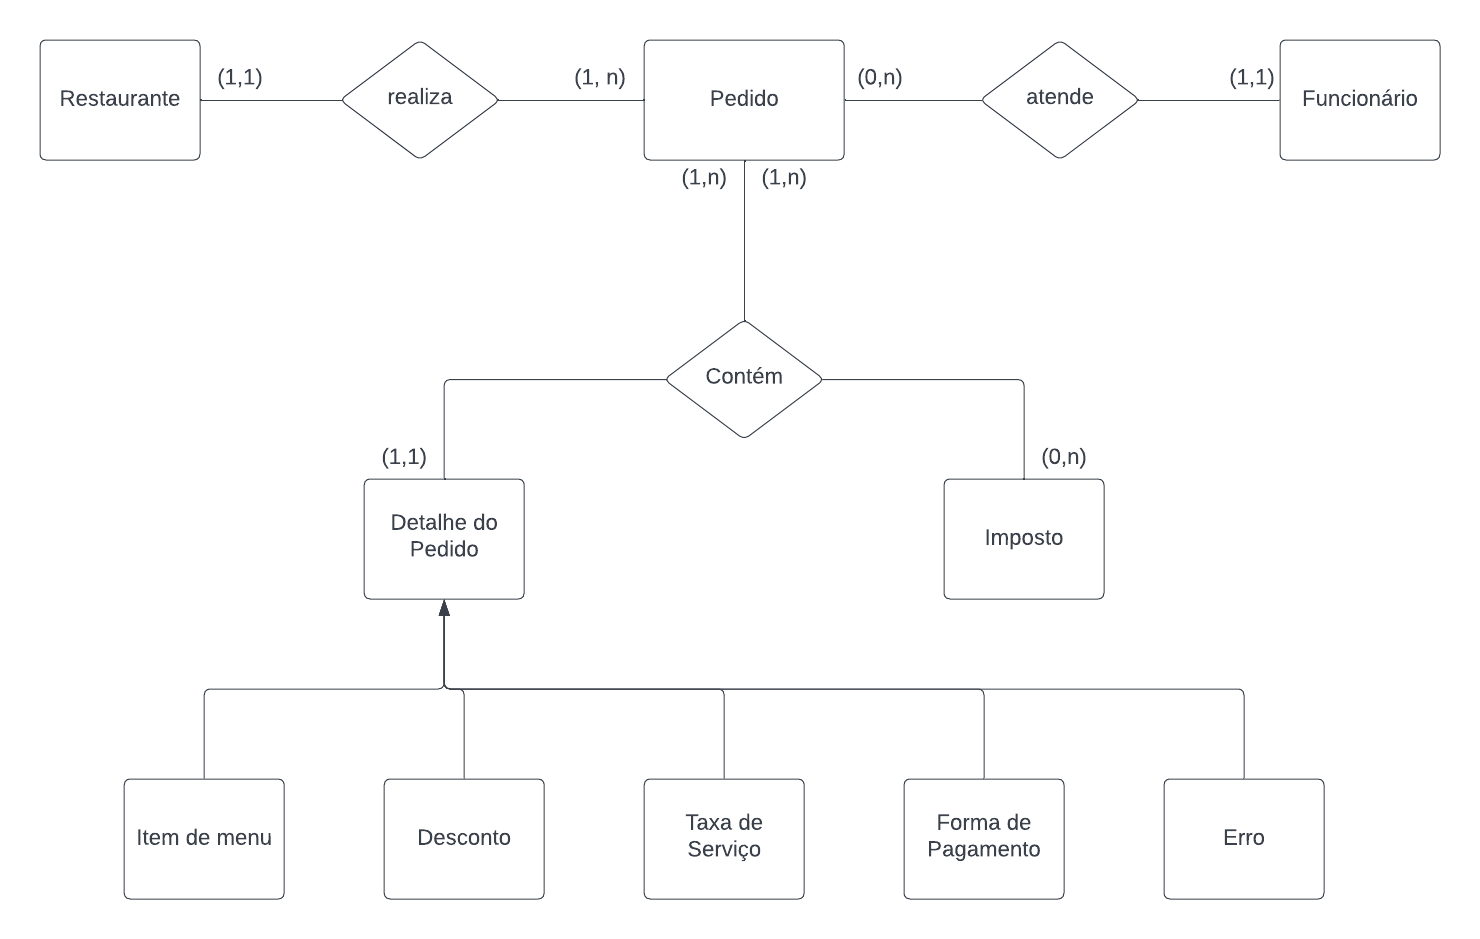

In [6]:
from IPython.display import Image

img = '../assets/MER.png'
Image(filename=img, width=650)

#### Entidades

As seguintes entidades foram identificadas como os pilares do negócio a partir da análise dos dados do ERP:

* **Restaurante:** Representa a unidade da cadeia onde a transação ocorre. (objeto raiz)
* **Funcionário:** A pessoa que atende e é responsável pelo pedido (entidade criada a partir do atributo `empNum` do objeto `guestChecks` por fins de normalização).
* **Pedido:** A entidade central que representa a transação de venda (`guestCheck`).
* **Imposto:** As taxas fiscais que são aplicadas sobre um pedido (`taxes`).
* **Detalhe do Pedido:** Uma entidade genérica que representa cada linha ou evento individual dentro de um pedido (`detailLines`).

#### Generalização e Especialização

A entidade `Detalhe do Pedido` ou `detailLines` é uma **superclasse (ou entidade genérica)**. Ela se especializa nos seguintes subtipos, que representam os diferentes tipos de eventos que podem ocorrer em um pedido:

* **Item de Menu:** Um item do cardápio que foi vendido.
* **Desconto:** Um desconto promocional aplicado.
* **Taxa de Serviço:** Uma taxa adicional, como gorjeta ou couvert.
* **Forma de Pagamento:** O meio utilizado para pagar a conta.
* **Erro:** Um registro de erro ou falha ocorrida durante o processo.

#### Relacionamentos e Cardinalidade

Os relacionamentos definem como as entidades interagem, e a cardinalidade define as regras de negócio dessa interação:

* Um **Restaurante** `realiza` um ou muitos **Pedidos** `(1:N)`.
* Um **Funcionário** `atende` zero ou muitos **Pedidos** `(0:N)`.
* Um **Pedido** `contém` zero ou muitos **Impostos** `(0:N)`.
* Um **Pedido** `contém` um e somente um **Detalhe do Pedido** `(1:1)`.

### 2.2. Modelagem Lógica (DER)

A etapa de **Modelagem Lógica** transforma o modelo conceitual em um esquema técnico detalhado. O Diagrama Entidade-Relacionamento (DER) abaixo ilustra essa estrutura, detalhando as tabelas, seus atributos, seus datatypes e os relacionamentos através de chaves primárias (PK) e estrangeiras (FK). O DER também foi criado com [Lucidchart](https://www.lucidchart.com/pages/pt/landing?km_CPC_CampaignId=1500131479&km_CPC_AdGroupID=57888677676&km_CPC_Keyword=%2Blucid%20%2Bchart&km_CPC_MatchType=b&km_CPC_ExtensionID=&km_CPC_Network=g&km_CPC_AdPosition=&km_CPC_Creative=286634000551&km_CPC_TargetID=kwd-311590324798&km_CPC_Country=9219142&km_CPC_Device=c&km_CPC_placement=&km_CPC_target=&gad_campaignid=1500131479).

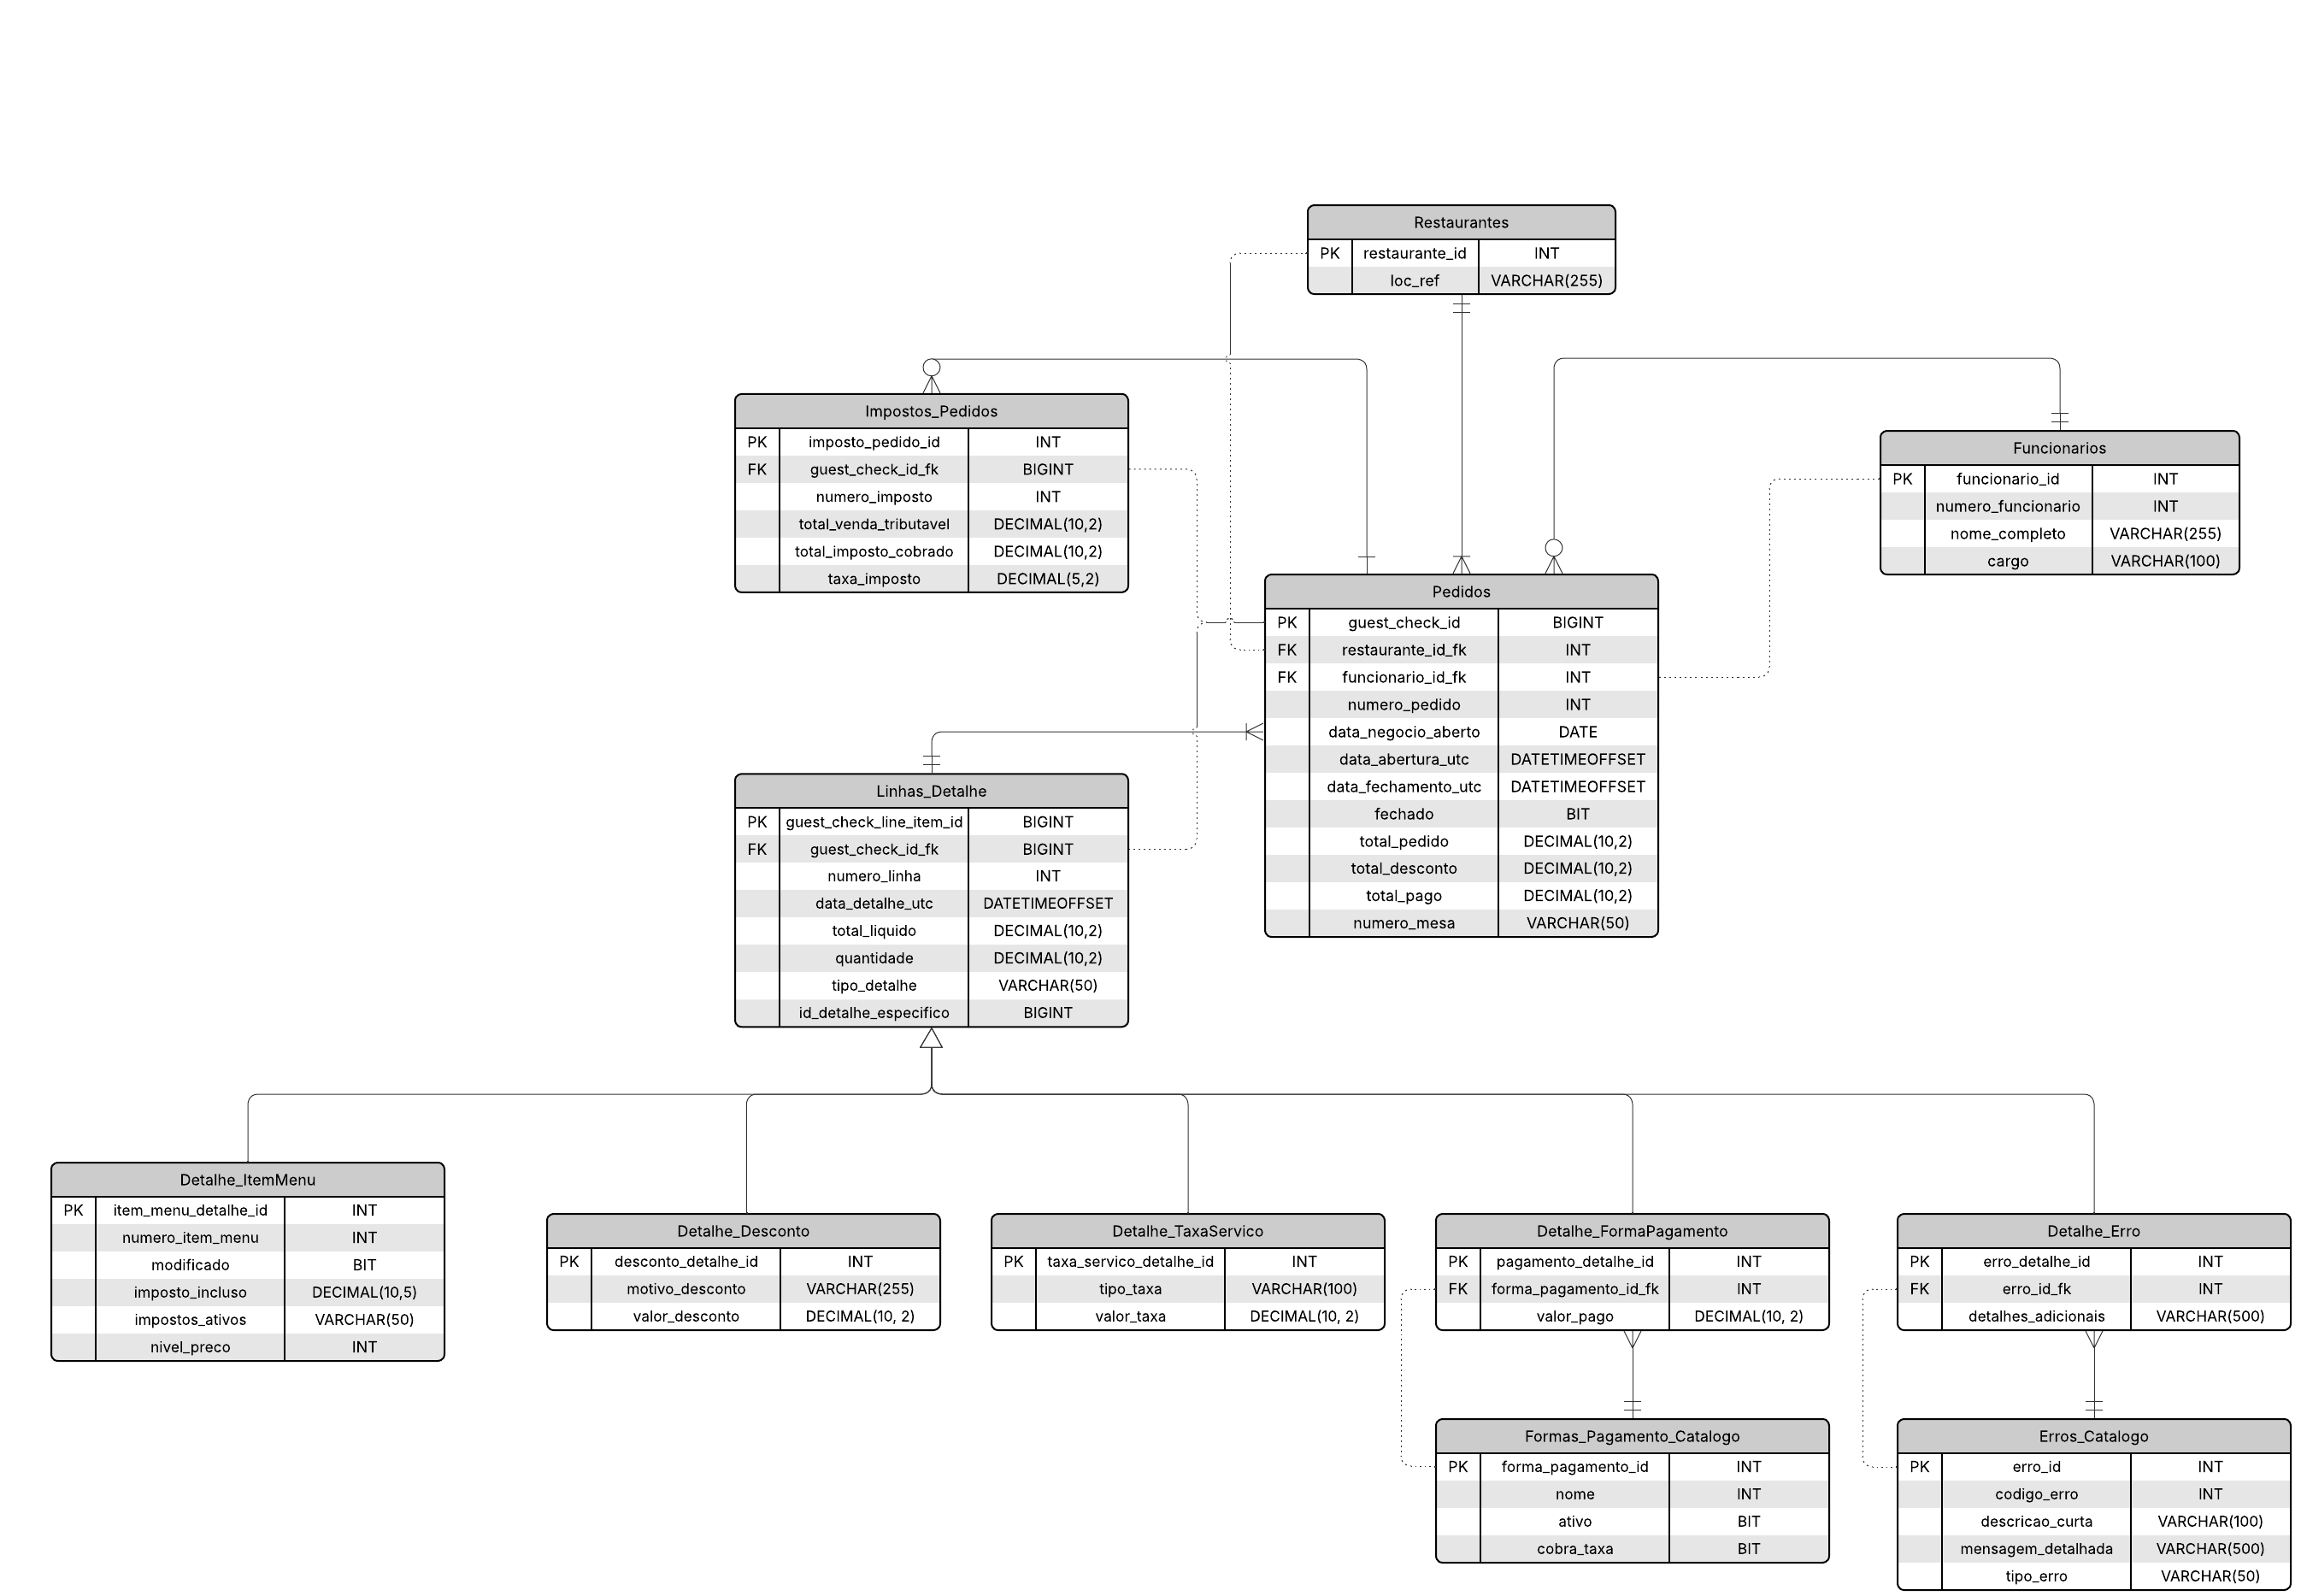

In [10]:
from IPython.display import Image

img = '../assets/DER.png'
Image(filename=img, width=1200)

#### Atributos descartados do arquivo ERP.json para evitar a redundância e garantir a integridade dos dados

A transformação de uma fonte de dados semi-estruturada como um JSON para um modelo relacional normalizado não é uma cópia direta. Muitos atributos do arquivo ERP.json foram descartados no modelo final para seguir os princípios de normalização, resultando em um banco de dados mais limpo, eficiente e íntegro.

Os atributos descartados se enquadram nas seguintes categorias:

* **Atributos Normalizados**: Informações que já existiam em uma tabela "pai" e que seriam repetidas desnecessariamente

  * `busDt` (em `detailLines`): A data do negócio já está presente na tabela Pedidos. Armazená-la em cada linha de detalhe seria altamente redundante.

  * `chkEmpId` e `chkEmpNum` (em `detailLines`): A informação do funcionário responsável pelo pedido como um todo já está na tabela Pedidos através de uma chave estrangeira. Repetir essa informação em cada detalhe é desnecessário
 
* **Metadados e Timestamps Locais**: Atributos que são redundantes ou servem para fins de auditoria no sistema de origem, mas não são essenciais para o modelo analítico final.

  * `opnLcl`, `clsdLcl`, `lastTransLcl`, `lastUpdatedLcl` (em `guestChecks`) e `detailLcl`, `lastUpdateLcl` (em `detailLines`): Todas as versões "Lcl" (Local) dos timestamps foram descartadas porque foi escolhido o tipo de dado DATETIMEOFFSET no SQL Server. Este tipo já armazena a informação do fuso horário, tornando a coluna de tempo local redundante.
  * `lastUpdatedUTC` e `lastUpdateUTC`: São campos de log/auditoria do sistema de origem. Para um modelo analítico, geralmente focamos nos timestamps de transação (`opnUTC`, `clsdUTC`, `detailUTC`). <br><br>

* **Identificadores Operacionais do ERP**: Muitos campos são IDs e contadores internos do sistema ERP de origem, que não possuem valor analítico direto e podem ser abstraídos no modelo de destino.

  * `rvcNum`, `otNum`, `ocNum`, `tblNum`, `dtlOtNum`, `dtlOcNum`, `dtlId`, `wsNum`, `svcRndNum`, `seatNum`. Manter esses campos poluiria o modelo com detalhes de implementação do sistema de origem. <br><br>

* **Campos de Cálculo Simplificados**: Atributos que representam cálculos financeiros que podem ser derivados ou que foram simplificados no modelo inicial.

  * `nonTxblSlsTtl`, `balDueTtl`, `aggTtl`, `aggQty`. Para o novo escopo, os totais principais (`chkTtl`, `payTtl`, `dspTtl`) foram considerados suficientes. 

#### Novas entidades criadas para assegurar a normalização

Para transformar a estrutura aninhada e, por vezes, textual do JSON em um modelo relacional robusto, foi necessário criar novas tabelas (entidades) que não correspondem diretamente a um objeto no arquivo de origem. Essas tabelas são fundamentais para garantir a consistência, a integridade e a escalabilidade do banco de dados.

* `Restaurantes` e `Funcionarios`:
  * No JSON, a loja e o funcionário são representados apenas por um código (`locRef` e `empNum`). Foram criadas as tabelas `Restaurantes` e `Funcionarios` como tabelas de dimensão ou mestre. Isso permite armazenar informações detalhadas sobre cada loja e cada funcionário em um único lugar, evitando repetição e permitindo análises mais ricas (ex: vendas por funcionário ou por loja).

* `Formas_Pagamento_Catalogo` e `Erros_Catalogo`:
  * Estas são tabelas de catálogo. Em vez de armazenar o nome da forma de pagamento ou a mensagem de erro como um texto livre em cada transação (o que levaria a inconsistências), foi criado um catálogo centralizado. As tabelas de transação (Detalhe_FormaPagamento e Detalhe_Erro) apenas referenciam o ID do catálogo. Isso garante consistência total dos dados e facilita a manutenção. 

* `Detalhe_*` (`Detalhe_ItemMenu`, `Detalhe_Desconto`, `Detalhe_TaxaServico`, `Detalhe_FormaPagamento`, `Detalhe_Erro`):
  * Esta é a solução para o problema do array polimórfico detailLines. Em vez de uma única tabela "faz-tudo" cheia de colunas nulas, foi criada uma tabela especializada para cada tipo de detalhe. Isso assegura que os dados de um item de menu (como miNum) só existam na tabela de itens de menu, e os dados de um desconto só existam na tabela de descontos, resultando em um design altamente normalizado e eficiente.

#### Datatypes (SQL Server)

As escolhas dos datatypes foram feitas pensando nas características dos dados do `ERP.json` e nas melhores práticas para um ambiente SQL Server.

* [**BIT**](https://learn.microsoft.com/pt-br/sql/t-sql/data-types/bit-transact-sql?view=sql-server-ver17)
    * **O que é:** Um tipo de dado extremamente eficiente para armazenar valores booleanos (verdadeiro/falso).
    * **Onde foi usado:** Em colunas como `fechado` (na tabela `Pedidos`), `modificado` (em `Detalhe_ItemMenu`) e `ativo` (em `Formas_Pagamento_Catalogo`).
    * **Justificativa:** Em vez de usar um texto como 'Sim'/'Não' ou 'Ativo'/'Inativo', o `BIT` armazena `1` (para Verdadeiro) ou `0` (para Falso). Isso economiza muito espaço de armazenamento e torna as consultas mais rápidas e padronizadas, eliminando a ambiguidade de valores textuais. <br><br>

* [**DATETIMEOFFSET**](https://learn.microsoft.com/en-us/sql/t-sql/data-types/datetimeoffset-transact-sql?view=sql-server-ver17)
    * **O que é:** Um tipo de dado que armazena a data, a hora e a informação do deslocamento em relação ao fuso horário UTC.
    * **Onde foi usado:** Em todas as colunas de timestamp, como `data_abertura_utc` e `data_detalhe_utc`.
    * **Justificativa:** O JSON de origem nos fornece timestamps com a designação "UTC", indicando que a informação de fuso horário é importante. `DATETIMEOFFSET` é o tipo ideal para preservar essa informação, garantindo que não haja ambiguidade sobre o momento exato de uma transação, independentemente da localização da loja. Usar um tipo mais simples como `DATETIME2` descartaria essa valiosa informação de fuso horário.<br><br>

* [**DECIMAL(p, s)**](https://learn.microsoft.com/pt-br/sql/t-sql/data-types/decimal-and-numeric-transact-sql?view=sql-server-ver16)
    * **O que é:** Um tipo de dado numérico com precisão e escala fixas, ideal para valores financeiros. `DECIMAL(10, 2)` significa um número com até 10 dígitos no total, sendo 2 deles após a vírgula.
    * **Onde foi usado:** Em todas as colunas monetárias, como `total_pedido` e `valor_desconto`.
    * **Justificativa:** Tipos de dados de ponto flutuante, como `FLOAT`, podem sofrer de pequenos erros de arredondamento que são inaceitáveis em cálculos financeiros. O `DECIMAL` foi projetado especificamente para armazenar valores monetários com precisão exata, garantindo que as somas e os cálculos financeiros sejam sempre corretos.<br><br>

* [**BIGINT**](https://learn.microsoft.com/pt-br/sql/t-sql/data-types/int-bigint-smallint-and-tinyint-transact-sql?view=sql-server-ver17)
    * **O que é:** Um tipo de número inteiro que suporta uma gama muito grande de valores (de -9 quintilhões a +9 quintilhões).
    * **Onde foi usado:** Nas chaves primárias que vêm do sistema de origem, como `guest_check_id` e `guest_check_line_item_id`.
    * **Justificativa:** O ID `guestCheckLineItemId` no JSON de exemplo é `9988776655`. Este número é grande demais para caber em um `INT` padrão (que vai até aproximadamente 2.1 bilhões). O uso de `BIGINT` garante que o banco de dados possa acomodar qualquer ID, por maior que seja, vindo do sistema ERP, evitando erros de estouro de capacidade no futuro.

### 2.2. Modelagem Física (SQL Server)